# Case 1: Heart Disease Classification

Luong Nguyen, 3/2/2019  
Cognitive Systems for Health Technology Applications  
Helsinki Metropolia University of Applied Sciences  
____

## Background

The goal of this notebook is to experiment with neural networks in classifying the presence of heart disease in the patients from the  [Heart Disease Data Set ](https://webcache.googleusercontent.com/search?q=cache:73nqPnhcT0UJ:https://archive.ics.uci.edu/ml/datasets/heart%2BDisease+&cd=1&hl=en&ct=clnk&gl=fi).
___

In [1]:
# Import libraries needed
%pylab inline
import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical
from keras import models, layers, regularizers

import itertools  

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Data preparation

In this section, we will first import the data and handle missing data. Next we will transform the dataset so that we can solve the binary classification problem if a patient has heart diseases or not. We will then split the dataset into training/validation set and finally normalize the data.

In [0]:
# Import data
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, 
                        sep = ',', 
                        header = None, 
                        index_col = None,
                        na_values = '?')

In [3]:
# Add column names
name_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']
df.columns = name_list

# Fill missing data with columnwise median values
df = df.fillna(df.median())

# Replace values of column 'num'
# 1, 2, 3, 4 will be turned to 1(presence of disease)
df.loc[df['num'] > 0, 'num'] = 1

# the first 5 rows of the dataframe
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
# Check the descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,3.158416,0.960126,1.0,3.0,3.0,4.0,4.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalac,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [5]:
# split dataframe into data and labels
data, labels = df.drop(columns=['num']), df['num']

# set seed so the validation set will stay the same 
np.random.seed(19)

# split train/val set
msk = np.random.rand(len(df)) < 0.7
train_data, val_data = data[msk], data[~msk]
train_labels, val_labels = labels[msk], labels[~msk]

print('Shape of')
print('  full data:        ', data.shape)
print('  train data:       ', train_data.shape)
print('  validation data:  ', val_data.shape)
print('  full labels:   ', labels.shape)
print('  train labels:     ', train_labels.shape)
print('  validation labels:', val_labels.shape)

Shape of
  full data:         (303, 13)
  train data:        (216, 13)
  validation data:   (87, 13)
  full labels:    (303,)
  train labels:      (216,)
  validation labels: (87,)


In [0]:
# normalize data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

val_data -= mean
val_data /= std

The data are now ready for training.
___

## Models and training

In this section, we will be experimenting different kinds of neural network and see how well they perform. 

### Baseline

In [7]:
positive = val_labels.sum() / len(val_labels)
baseline = positive if positive > 0.5 else 1 - positive
print(f'Percentage of patients with heart diseases in the validation set: {baseline * 100:.3f}%')

Percentage of patients with heart diseases in the validation set: 51.724%


If we predict all the patients have heart diseases, we will achieve about 52% accuracy, still a little bit better than `50-50`. Let's see how much we can do better with the power of deep learning.

### Logistic regression

Before using neural networks, let's see how simple logistic regression works on this problem.

In [11]:
# build model
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid',input_shape=(train_data.shape[1],)))
model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train model
def train(epochs, batch_size):
  return model.fit(train_data, train_labels, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    verbose = 0,
                    validation_data = (val_data, val_labels))

history = train(epochs=100, batch_size=32)

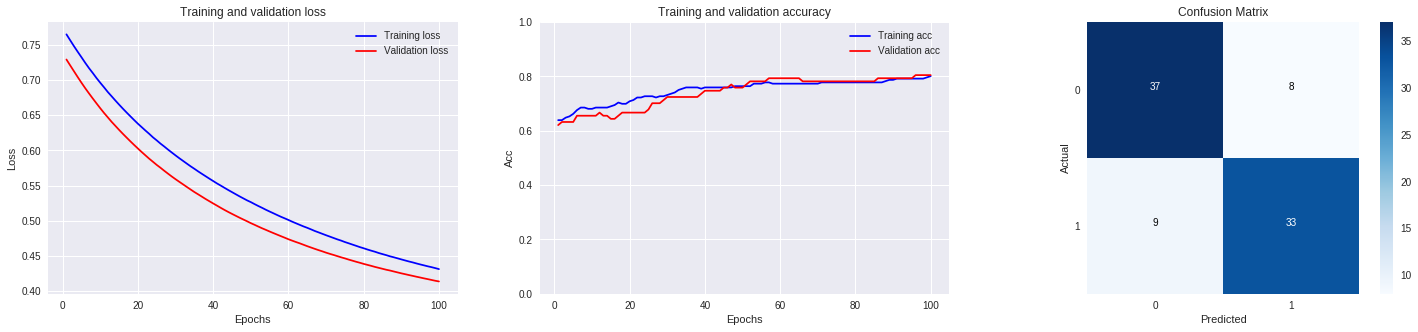

In [16]:
# https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
 def plot_confusion_matrix():
  cf = confusion_matrix(val_labels, model.predict(val_data) > 0.5)
  plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
  plt.grid(False)
  plt.colorbar()
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  tick_marks = [0, 1]
  class_labels = ['0','1']
  tick_marks
  plt.xticks(tick_marks,class_labels)
  plt.yticks(tick_marks,class_labels)
  # plotting text value inside cells
  thresh = cf.max() / 2.
  for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
      plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
      
      
def plot():
  """
  Plot the training/validation loss/accuracy graphs and confusion matrix  
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  epochs = range(1, len(loss) + 1)
  
  plt.figure(figsize=(18,5))
  
  plt.subplots_adjust(right=1.2)
  plt.subplot(1, 3, 1)
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.ylim([0, 1])
  plt.legend()
  
  plt.subplot(1, 3, 3)
  plot_confusion_matrix()

  plt.show()
  
plot()

A single logistic regression unit was able to achieve about 80% accuracy. 

### Single hidden layer network

Next, we will add a hidden layer and experiment with the number of units in the layer.

#### 8-unit hidden layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 112       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


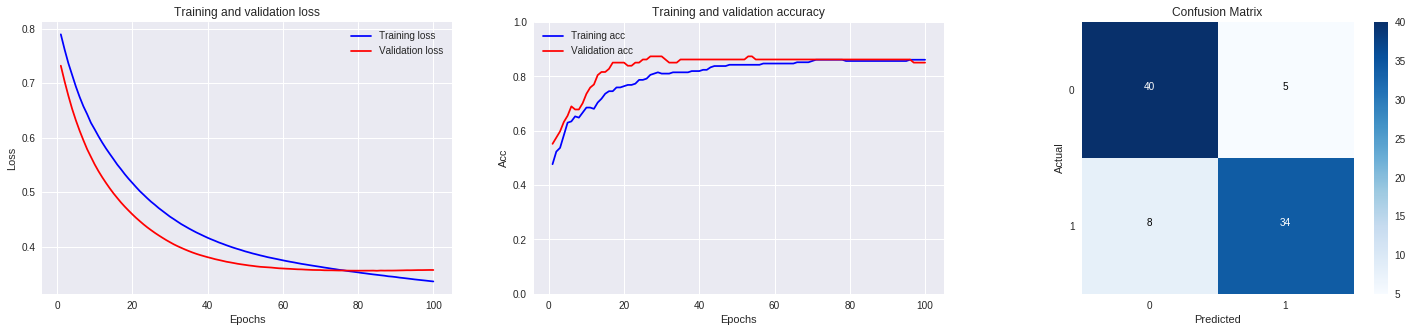

In [17]:
# build model
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# train
history = train(epochs=100, batch_size=32)
# plot result
plot()

With a 8-unit hidden layer, the model achieved about 85% accuracy but started overfitting after about 80 epochs.

#### 64-unit hidden layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


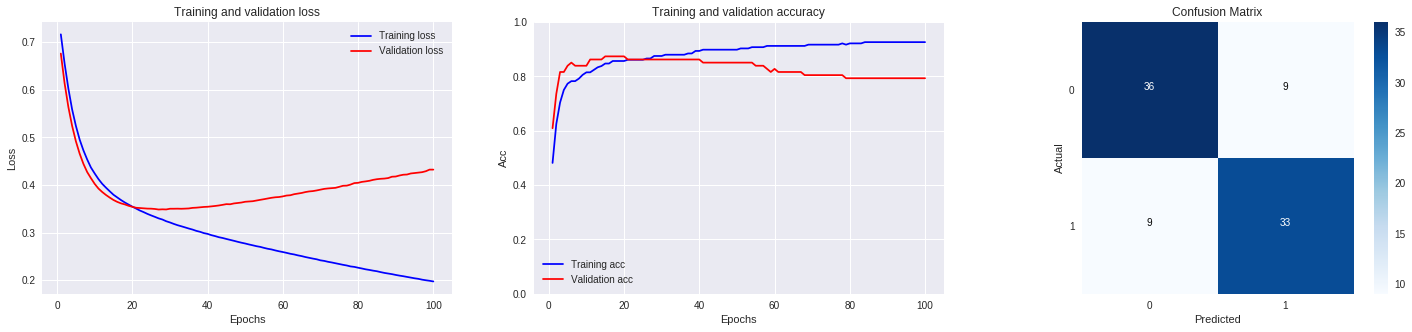

In [18]:
# build model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# train
history = train(epochs=100, batch_size=32)
# plot result
plot()

By increasing the number of units, the loss dropped quickly and started overfitting after only 20 epochs. However, the model achieved nearly 90% accuracy after 20 epochs.  

### 2-hidden-layer network

Let's see what happen if we add another 64-unit hidden layer.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


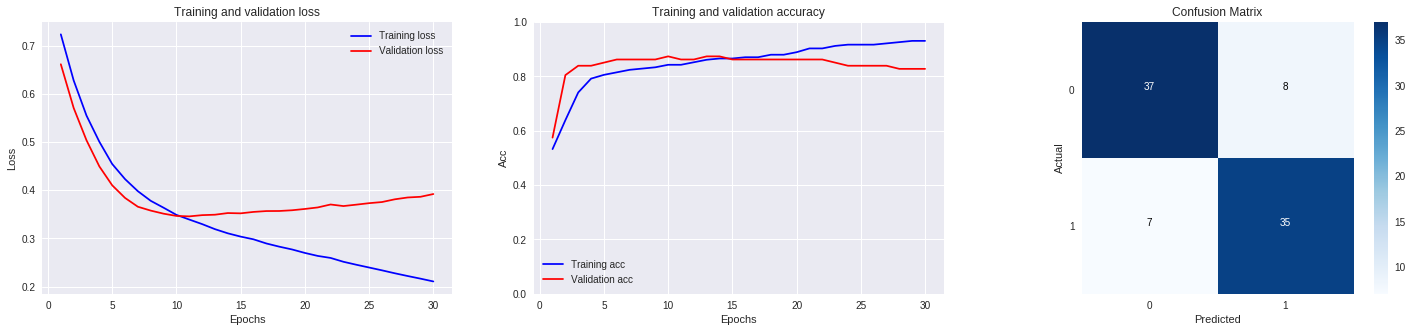

In [19]:
# build model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# train
history = train(epochs=30, batch_size=32)
# plot result
plot()

Adding another hidden layer, this model started overfitting after only 10 epochs and achieved the same level of the previous model. Let's see if we can achieve better performance by applying some methods to counter overfitting.

### Fight overfitting

#### Reduce size of the network

The previous model with 2 hidden layers of 64-units was able to bring the loss down very quickly and start overfitting right away. To counter overfitting, first we will reduce the number of units in each layer to 8.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 8)                 112       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


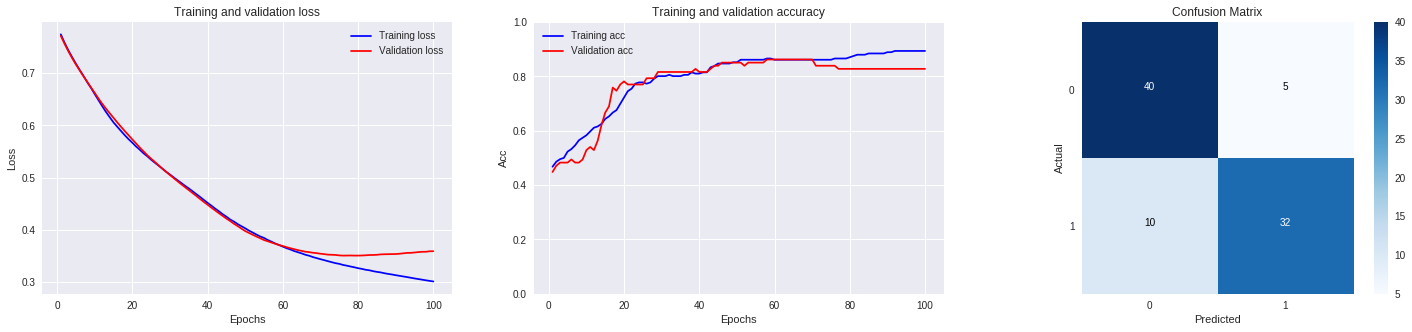

In [23]:
# build model
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# train
history = train(epochs=100, batch_size=32)
# plot result
plot()

This smaller network started overfitting later than the previous one, and the performance degraded more slowly once it started overfitting. 

#### Using dropout layers

Let's add 2 dropout layers to see how they help reducing overfitting.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 8)                 112       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


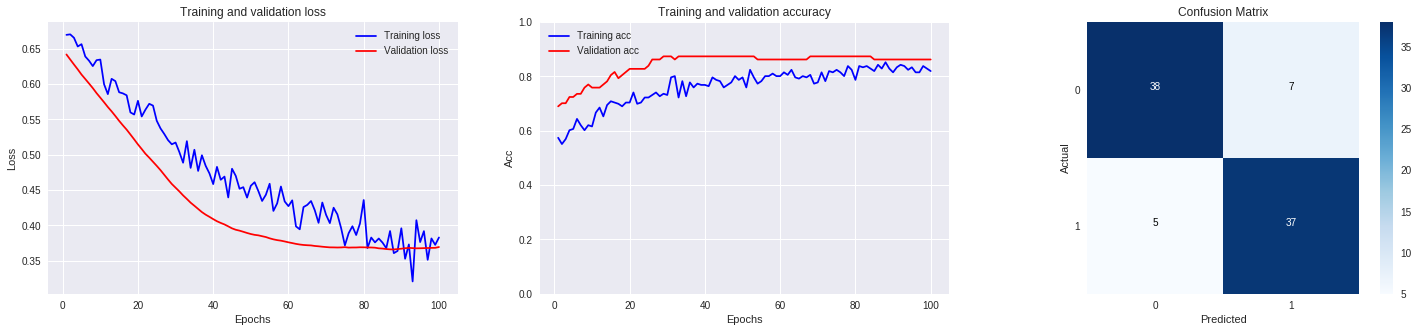

In [26]:
# build model
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dropout(0.20))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.20))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# train
history = train(epochs=100, batch_size=32)
# plot result
plot()


Adding dropout layers makes the training loss and acc noisier, however it clearly helped reducing overfitting. 

## Conclusion

Using only simple logistic regression achieved 80% accuracy, already a big improvement over the baseline of 52%. Using single hidden layer with 8 units, the model achieved above 85% accuracy and only started overfitting after 80 epochs. Increase the number of units to 64, the model reached nearly 90% accuracy after only 20 epochs then overfitted heavily.  Adding another hidden layer, the model did not perform clearly better and overfitted after only 10 epochs.  
To counter overfitting, first we reduced the capacity of the model then added dropout layers, which clearly worked. We have a model that almost reached 90% accuracy and is general enough to feed the test set into if available. If I were more experienced with deep learning, I believed tweaking the learning rate of the optimizer instead of using the default one could result in a better model.
Overall, this case study helps me gain more intuition about deep learning e.g. choosing hyperparameters. For the next deep learning tasks, my approach would be starting with a big network that can still be trained in a reasonable amount of time, train it a few epochs until it starts overfitting, then apply counter overfitting methods. Can't wait for case 2. 